In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install captum
!pip install torchmetrics
%pip install 'drive/MyDrive/encoder_attribution_priors/.'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.6 MB/s eta 0:00:00
Processing ./drive/MyDrive/encoder_attribution_priors
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lfxai: filename=lfxai-0.1.1-py3-none-any.whl size=31039 sha256=80736f1ce303d5124d8368d8654bb0a9ff4cb2d1bb1a9f1e8f2ee1b8a81545e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-qxyrb6ue/wheels/7b/00/41/6fc986ab56840bbe22a1da3b92c41c9d55e2dcd851163270b7
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=f816bfd9f918f83e1592cce53d7

In [3]:
import argparse
import csv
import itertools
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from captum.attr import GradientShap, IntegratedGradients, Saliency
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, RandomSampler, Subset
from torchvision import transforms

from lfxai.explanations.examples import (
    InfluenceFunctions,
    NearestNeighbours,
    SimplEx,
    TracIn,
)
from lfxai.explanations.features import attribute_auxiliary, attribute_individual_dim, tensor_attribution, attribute_training
from lfxai.models.images import (
    VAE,
    AutoEncoderMnist,
    ClassifierMnist,
    DecoderBurgess,
    DecoderMnist,
    EncoderBurgess,
    EncoderMnist,
)
from lfxai.models.losses import BetaHLoss, BtcvaeLoss, EntropyLoss, PearsonLoss, TotalVariationLoss, _total_variation_loss
from lfxai.models.pretext import Identity, Mask, RandomNoise
from lfxai.utils.datasets import MaskedMNIST
from lfxai.utils.feature_attribution import generate_masks
from lfxai.utils.metrics import (
    compute_metrics,
    cos_saliency,
    count_activated_neurons,
    entropy_saliency_tensor,
    entropy_saliency,
    pearson_saliency,
    similarity_rates,
    spearman_saliency,
    pearson_saliency_tensor
)
from lfxai.utils.visualize import (
    correlation_latex_table,
    plot_pretext_saliencies,
    plot_pretext_top_example,
    plot_vae_saliencies,
    vae_box_plots,
)

In [ ]:
W=32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_dir = Path.cwd() / "data/mnist"

img_size = (1, W, W)
encoder = EncoderBurgess(img_size, 3)

baseline_image = torch.zeros((1, 1, W, W), device=device)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)


test_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
test_dataset.transform = test_transform
test_dataset.data, test_dataset.targets = test_dataset.data[[1,2,3,4,5]], test_dataset.targets[[1,2,3,4,5]]
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

gradshap = GradientShap(encoder.mu)

100%|██████████| 9912422/9912422 [00:00<00:00, 168419541.78it/s]

Extracting /content/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 58238314.34it/s]


Extracting /content/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50799848.66it/s]

Extracting /content/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18212742.61it/s]


Extracting /content/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/mnist/MNIST/raw



In [ ]:
saliency_tensor = tensor_attribution(encoder.mu, 3, test_loader, device, gradshap, baseline_image)
saliency_array = attribute_individual_dim(encoder.mu, 3, test_loader, device, gradshap, baseline_image)

In [ ]:
def disvae_feature_importance(
    random_seed: int = 1,
    batch_size: int = 300,
    n_plots: int = 20,
    n_runs: int = 5,
    dim_latent: int = 3,
    n_epochs: int = 50,
    beta_list: list = [1],
) -> None:
    # Initialize seed and device
    np.random.seed(random_seed)
    torch.random.manual_seed(random_seed)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Load MNIST
    W = 32
    img_size = (1, W, W)
    data_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/data/mnist"
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)
    train_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    test_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    train_dataset.transform = train_transform
    test_dataset.transform = test_transform
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Create saving directory
    save_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/vae"
    if not save_dir.exists():

        print(f"Creating saving directory {save_dir}")
        os.makedirs(save_dir)

    # Define the computed metrics and create a csv file with appropriate headers
    loss_list = [BetaHLoss()]
    metric_list = [
        pearson_saliency,
        entropy_saliency,
        count_activated_neurons,
    ]
    metric_names = [
        "Pearson Correlation",
        "Entropy",
        "Active Neurons",
    ]
    headers = ["Loss Type", "Beta"] + metric_names
    csv_path = save_dir / "metrics.csv"
    if not csv_path.is_file():
        print(f"Creating metrics csv in {csv_path}")

        with open(csv_path, "w") as csv_file:
            dw = csv.DictWriter(csv_file, delimiter=",", fieldnames=headers)
            dw.writeheader()

    for beta, loss, run in itertools.product(
        beta_list, loss_list, range(1, n_runs + 1)
    ):
        # Initialize vaes
        encoder = EncoderBurgess(img_size, dim_latent)
        decoder = DecoderBurgess(img_size, dim_latent)
        loss.beta = beta
        name = f"{str(loss)}-vae_beta{beta}_run{run}"
        model = VAE(img_size, encoder, decoder, dim_latent, loss, name=name)
        print(f"Now fitting {name}")

        model.fit(device, train_loader, test_loader, save_dir, n_epochs)
        model.load_state_dict(torch.load(save_dir / (name + ".pt")), strict=False)

        # Compute test-set saliency and associated metrics
        baseline_image = torch.zeros((1, 1, W, W), device=device)
        gradshap = GradientShap(encoder.mu)
        attributions = attribute_individual_dim(
            encoder.mu, dim_latent, test_loader, device, gradshap, baseline_image
        )
        metrics = compute_metrics(attributions, metric_list)
        results_str = "\t".join(
            [f"{metric_names[k]} {metrics[k]:.2g}" for k in range(len(metric_list))]
        )
        print(f"Model {name} \t {results_str}")


        # Save the metrics
        with open(csv_path, "a", newline="") as csv_file:
            writer = csv.writer(csv_file, delimiter=",")
            writer.writerow([str(loss), beta] + metrics)

        # Plot a couple of examples
        plot_idx = [
            torch.nonzero(test_dataset.targets == (n % 10))[n // 10].item()
            for n in range(n_plots)
        ]
        images_to_plot = [test_dataset[i][0].numpy().reshape(W, W) for i in plot_idx]
        fig = plot_vae_saliencies(images_to_plot, attributions[plot_idx])
        fig.savefig(save_dir / f"{name}.pdf")
        plt.close(fig)

In [ ]:
disvae_feature_importance()

Creating saving directory /content/drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/vae
Creating metrics csv in /content/drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/vae/metrics.csv
Now fitting Beta-vae_beta1_run1


Epoch 1/50 	 
Train loss 303 	 Test loss 256 	 


Epoch 2/50 	 
Train loss 251 	 Test loss 247 	 


Epoch 3/50 	 
Train loss 245 	 Test loss 243 	 


Epoch 4/50 	 
Train loss 232 	 Test loss 224 	 


Epoch 5/50 	 
Train loss 219 	 Test loss 215 	 


Epoch 6/50 	 
Train loss 214 	 Test loss 212 	 


Epoch 7/50 	 
Train loss 208 	 Test loss 201 	 


Epoch 8/50 	 
Train loss 198 	 Test loss 195 	 


Epoch 9/50 	 
Train loss 193 	 Test loss 191 	 


Epoch 10/50 	 
Train loss 191 	 Test loss 189 	 


Epoch 11/50 	 
Train loss 189 	 Test loss 188 	 


Epoch 12/50 	 
Train loss 187 	 Test loss 187 	 


Epoch 13/50 	 
Train loss 186 	 Test loss 186 	 


Epoch 14/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 15/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 16/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 17/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 18/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 19/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 20/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 22/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 23/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 25/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 26/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 27/50 	 
Train loss 179 	 Test loss 181 	 


Epoch 28/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 33/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 34/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 35/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 180 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 40/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 41/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 42/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 50/50 	 
Train loss 175 	 Test loss 178 	 
Model Beta-vae_beta1_run1 	 Pearson Correlation 0.28	Entropy 0.72	Active Neurons 1.3
Now fitting Beta-vae_beta1_run2


Epoch 1/50 	 
Train loss 304 	 Test loss 257 	 


Epoch 2/50 	 
Train loss 250 	 Test loss 246 	 


Epoch 3/50 	 
Train loss 245 	 Test loss 242 	 


Epoch 4/50 	 
Train loss 241 	 Test loss 238 	 


Epoch 5/50 	 
Train loss 227 	 Test loss 221 	 


Epoch 6/50 	 
Train loss 216 	 Test loss 214 	 


Epoch 7/50 	 
Train loss 211 	 Test loss 211 	 


Epoch 8/50 	 
Train loss 208 	 Test loss 206 	 


Epoch 9/50 	 
Train loss 205 	 Test loss 204 	 


Epoch 10/50 	 
Train loss 201 	 Test loss 195 	 


Epoch 11/50 	 
Train loss 194 	 Test loss 192 	 


Epoch 12/50 	 
Train loss 191 	 Test loss 189 	 


Epoch 13/50 	 
Train loss 189 	 Test loss 188 	 


Epoch 14/50 	 
Train loss 188 	 Test loss 186 	 


Epoch 15/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 16/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 17/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 18/50 	 
Train loss 184 	 Test loss 183 	 


Epoch 19/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 20/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 21/50 	 
Train loss 183 	 Test loss 182 	 


Epoch 22/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 23/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 24/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 25/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 26/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 27/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 28/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 31/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 32/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 33/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 34/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 35/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 36/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 37/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 39/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 40/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 41/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 42/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 44/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 50/50 	 
Train loss 176 	 Test loss 177 	 
Model Beta-vae_beta1_run2 	 Pearson Correlation 0.25	Entropy 0.68	Active Neurons 1.3
Now fitting Beta-vae_beta1_run3


Epoch 1/50 	 
Train loss 294 	 Test loss 255 	 


Epoch 2/50 	 
Train loss 251 	 Test loss 248 	 


Epoch 3/50 	 
Train loss 238 	 Test loss 226 	 


Epoch 4/50 	 
Train loss 215 	 Test loss 207 	 


Epoch 5/50 	 
Train loss 205 	 Test loss 202 	 


Epoch 6/50 	 
Train loss 200 	 Test loss 196 	 


Epoch 7/50 	 
Train loss 195 	 Test loss 193 	 


Epoch 8/50 	 
Train loss 192 	 Test loss 190 	 


Epoch 9/50 	 
Train loss 190 	 Test loss 189 	 


Epoch 10/50 	 
Train loss 188 	 Test loss 187 	 


Epoch 11/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 12/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 13/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 14/50 	 
Train loss 184 	 Test loss 183 	 


Epoch 15/50 	 
Train loss 183 	 Test loss 182 	 


Epoch 16/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 17/50 	 
Train loss 182 	 Test loss 181 	 


Epoch 18/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 19/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 20/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 21/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 22/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 23/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 24/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 25/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 26/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 27/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 28/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 29/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 30/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 31/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 32/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 33/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 34/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 177 	 


Epoch 36/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 37/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 38/50 	 
Train loss 175 	 Test loss 176 	 


Epoch 39/50 	 
Train loss 175 	 Test loss 176 	 


Epoch 40/50 	 
Train loss 175 	 Test loss 176 	 


Epoch 41/50 	 
Train loss 175 	 Test loss 176 	 


Epoch 42/50 	 
Train loss 175 	 Test loss 176 	 


Epoch 43/50 	 
Train loss 175 	 Test loss 176 	 


Epoch 44/50 	 
Train loss 175 	 Test loss 176 	 


Epoch 45/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 46/50 	 
Train loss 175 	 Test loss 176 	 


Epoch 47/50 	 
Train loss 174 	 Test loss 176 	 


Epoch 48/50 	 
Train loss 174 	 Test loss 176 	 


Epoch 49/50 	 
Train loss 174 	 Test loss 176 	 


Epoch 50/50 	 
Train loss 174 	 Test loss 176 	 
Model Beta-vae_beta1_run3 	 Pearson Correlation 0.27	Entropy 0.71	Active Neurons 1.3
Now fitting Beta-vae_beta1_run4


Epoch 1/50 	 
Train loss 301 	 Test loss 256 	 


Epoch 2/50 	 
Train loss 251 	 Test loss 248 	 


Epoch 3/50 	 
Train loss 236 	 Test loss 224 	 


Epoch 4/50 	 
Train loss 211 	 Test loss 203 	 


Epoch 5/50 	 
Train loss 200 	 Test loss 197 	 


Epoch 6/50 	 
Train loss 195 	 Test loss 193 	 


Epoch 7/50 	 
Train loss 192 	 Test loss 190 	 


Epoch 8/50 	 
Train loss 190 	 Test loss 188 	 


Epoch 9/50 	 
Train loss 188 	 Test loss 187 	 


Epoch 10/50 	 
Train loss 187 	 Test loss 187 	 


Epoch 11/50 	 
Train loss 186 	 Test loss 186 	 


Epoch 12/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 13/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 14/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 15/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 16/50 	 
Train loss 183 	 Test loss 182 	 


Epoch 17/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 18/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 19/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 20/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 22/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 23/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 25/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 26/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 27/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 28/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 32/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 33/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 34/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 37/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 38/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 39/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 40/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 41/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 43/50 	 
Train loss 175 	 Test loss 178 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 46/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 47/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 48/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 49/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 50/50 	 
Train loss 175 	 Test loss 176 	 
Model Beta-vae_beta1_run4 	 Pearson Correlation 0.24	Entropy 0.7	Active Neurons 1.3
Now fitting Beta-vae_beta1_run5


Epoch 1/50 	 
Train loss 311 	 Test loss 263 	 


Epoch 2/50 	 
Train loss 253 	 Test loss 248 	 


Epoch 3/50 	 
Train loss 244 	 Test loss 233 	 


Epoch 4/50 	 
Train loss 228 	 Test loss 222 	 


Epoch 5/50 	 
Train loss 218 	 Test loss 211 	 


Epoch 6/50 	 
Train loss 204 	 Test loss 199 	 


Epoch 7/50 	 
Train loss 197 	 Test loss 195 	 


Epoch 8/50 	 
Train loss 194 	 Test loss 191 	 


Epoch 9/50 	 
Train loss 191 	 Test loss 189 	 


Epoch 10/50 	 
Train loss 190 	 Test loss 188 	 


Epoch 11/50 	 
Train loss 189 	 Test loss 188 	 


Epoch 12/50 	 
Train loss 187 	 Test loss 187 	 


Epoch 13/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 14/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 15/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 16/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 17/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 18/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 19/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 20/50 	 
Train loss 183 	 Test loss 182 	 


Epoch 21/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 22/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 23/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 24/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 25/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 26/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 27/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 28/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 31/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 32/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 33/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 34/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 35/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 36/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 37/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 39/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 40/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 41/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 44/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 47/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 50/50 	 
Train loss 176 	 Test loss 178 	 
Model Beta-vae_beta1_run5 	 Pearson Correlation 0.26	Entropy 0.71	Active Neurons 1.3


In [ ]:
 def entropy_vae(
    random_seed: int = 1,
    batch_size: int = 300,
    n_plots: int = 20,
    n_runs: int = 1,
    dim_latent: int = 3,
    n_epochs: int = 50,
    alpha_list: list = [0.5],
) -> None:
    # Initialize seed and device
    np.random.seed(random_seed)
    torch.random.manual_seed(random_seed)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Load MNIST
    W = 32
    img_size = (1, W, W)
    data_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/data/mnist"
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    #train_dataset.data, train_dataset.targets = train_dataset.data[[i for i in range(50)]], train_dataset.targets[[i for i in range(50)]]
    test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)
    #test_dataset.data, test_dataset.targets = test_dataset.data[[i for i in range(50)]], test_dataset.targets[[i for i in range(50)]]
    train_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    test_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    train_dataset.transform = train_transform
    test_dataset.transform = test_transform
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Create saving directory
    save_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/entropy_vae"
    if not save_dir.exists():

        print(f"Creating saving directory {save_dir}")
        os.makedirs(save_dir)

    # Define the computed metrics and create a csv file with appropriate headers
    loss_list = [EntropyLoss()]
    metric_list = [
        pearson_saliency,
        entropy_saliency,
        count_activated_neurons,
    ]
    metric_names = [
        "Pearson Correlation",
        "Entropy",
        "Active Neurons",
    ]
    headers = ["Loss Type", "Alpha"] + metric_names
    csv_path = save_dir / "metrics.csv"
    if not csv_path.is_file():
        print(f"Creating metrics csv in {csv_path}")

        with open(csv_path, "w") as csv_file:
            dw = csv.DictWriter(csv_file, delimiter=",", fieldnames=headers)
            dw.writeheader()

    for alpha, loss, run in itertools.product(
        alpha_list, loss_list, range(1, n_runs + 1)
    ):
        # Initialize vaes
        encoder = EncoderBurgess(img_size, dim_latent)
        decoder = DecoderBurgess(img_size, dim_latent)
        loss.alpha = alpha
        name = f"{str(loss)}-vae_alpha{alpha}_run{run}"
        model = VAE(img_size, encoder, decoder, dim_latent, loss, name=name)
        print(f"Now fitting {name}")

        model.fit(device, train_loader, test_loader, save_dir, n_epochs)
        model.load_state_dict(torch.load(save_dir / (name + ".pt")), strict=False)

        # Compute test-set saliency and associated metrics
        baseline_image = torch.zeros((1, 1, W, W), device=device)
        gradshap = GradientShap(encoder.mu)
        attributions = attribute_individual_dim(
            encoder.mu, dim_latent, test_loader, device, gradshap, baseline_image
        )
        metrics = compute_metrics(attributions, metric_list)
        results_str = "\t".join(
            [f"{metric_names[k]} {metrics[k]:.2g}" for k in range(len(metric_list))]
        )
        print(f"Model {name} \t {results_str}")


        # Save the metrics
        with open(csv_path, "a", newline="") as csv_file:
            writer = csv.writer(csv_file, delimiter=",")
            writer.writerow([str(loss), alpha] + metrics)

        # Plot a couple of examples
        plot_idx = [
            torch.nonzero(test_dataset.targets == (n % 10))[n // 10].item()
            for n in range(n_plots)
        ]
        images_to_plot = [test_dataset[i][0].numpy().reshape(W, W) for i in plot_idx]
        fig = plot_vae_saliencies(images_to_plot, attributions[plot_idx])
        fig.savefig(save_dir / f"{name}.pdf")
        plt.close(fig)

In [ ]:
entropy_vae(alpha_list=[0.5])

Creating saving directory /content/drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/entropy_vae
Creating metrics csv in /content/drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/entropy_vae/metrics.csv
Now fitting Entropy-vae_alpha0.5_run1


Epoch 1/50 	 
Train loss 305 	 Test loss 256 	 


Epoch 2/50 	 
Train loss 252 	 Test loss 249 	 


Epoch 3/50 	 
Train loss 242 	 Test loss 250 	 


Epoch 4/50 	 
Train loss 232 	 Test loss 253 	 


Epoch 5/50 	 
Train loss 226 	 Test loss 233 	 


Epoch 6/50 	 
Train loss 219 	 Test loss 210 	 


Epoch 7/50 	 
Train loss 204 	 Test loss 199 	 


Epoch 8/50 	 
Train loss 197 	 Test loss 194 	 


Epoch 9/50 	 
Train loss 193 	 Test loss 191 	 


Epoch 10/50 	 
Train loss 191 	 Test loss 189 	 


Epoch 11/50 	 
Train loss 189 	 Test loss 187 	 


Epoch 12/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 13/50 	 
Train loss 186 	 Test loss 186 	 


Epoch 14/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 15/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 16/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 17/50 	 
Train loss 184 	 Test loss 183 	 


Epoch 18/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 19/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 20/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 21/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 22/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 23/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 24/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 25/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 26/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 27/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 28/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 30/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 31/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 32/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 33/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 34/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 35/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 36/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 37/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 39/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 40/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 41/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 42/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 44/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 46/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 47/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 48/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 49/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 50/50 	 
Train loss 177 	 Test loss 178 	 
Model Entropy-vae_alpha0.5_run1 	 Pearson Correlation 0.28	Entropy 0.71	Active Neurons 1.3
Now fitting Entropy-vae_alpha0.5_run2


Epoch 1/50 	 
Train loss 311 	 Test loss 273 	 


Epoch 2/50 	 
Train loss 272 	 Test loss 274 	 


Epoch 3/50 	 
Train loss 255 	 Test loss 250 	 


Epoch 4/50 	 
Train loss 246 	 Test loss 248 	 


Epoch 5/50 	 
Train loss 236 	 Test loss 249 	 


Epoch 6/50 	 
Train loss 228 	 Test loss 253 	 


Epoch 7/50 	 
Train loss 223 	 Test loss 228 	 


Epoch 8/50 	 
Train loss 217 	 Test loss 214 	 


Epoch 9/50 	 
Train loss 206 	 Test loss 199 	 


KeyboardInterrupt: ignored

In [ ]:
entropy_vae(alpha_list=[1])

Now fitting Entropy-vae_alpha1_run1


Epoch 1/50 	 
Train loss 307 	 Test loss 258 	 


Epoch 2/50 	 
Train loss 252 	 Test loss 248 	 


Epoch 3/50 	 
Train loss 241 	 Test loss 250 	 


Epoch 4/50 	 
Train loss 231 	 Test loss 255 	 


Epoch 5/50 	 
Train loss 225 	 Test loss 254 	 


Epoch 6/50 	 
Train loss 222 	 Test loss 257 	 


Epoch 7/50 	 
Train loss 219 	 Test loss 257 	 


Epoch 8/50 	 
Train loss 217 	 Test loss 257 	 


Epoch 9/50 	 
Train loss 216 	 Test loss 252 	 


Epoch 10/50 	 
Train loss 214 	 Test loss 253 	 


Epoch 11/50 	 
Train loss 213 	 Test loss 255 	 


Epoch 12/50 	 
Train loss 212 	 Test loss 255 	 
Model Entropy-vae_alpha1_run1 	 Pearson Correlation 0.47	Entropy 0.029	Active Neurons 1


In [ ]:
entropy_vae(alpha_list=[5])

Now fitting Entropy-vae_alpha5_run1


Epoch 1/50 	 
Train loss 312 	 Test loss 273 	 


Epoch 2/50 	 
Train loss 273 	 Test loss 272 	 


Epoch 3/50 	 
Train loss 273 	 Test loss 272 	 


Epoch 4/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 5/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 6/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 7/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 8/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 9/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 10/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 11/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 12/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 13/50 	 
Train loss 272 	 Test loss 272 	 


Epoch 14/50 	 
Train loss 267 	 Test loss 252 	 


Epoch 15/50 	 
Train loss 249 	 Test loss 245 	 


Epoch 16/50 	 
Train loss 239 	 Test loss 245 	 


Epoch 17/50 	 
Train loss 226 	 Test loss 253 	 


Epoch 18/50 	 
Train loss 219 	 Test loss 253 	 


Epoch 19/50 	 
Train loss 218 	 Test loss 257 	 


Epoch 20/50 	 
Train loss 215 	 Test loss 255 	 


Epoch 21/50 	 
Train loss 213 	 Test loss 259 	 


Epoch 22/50 	 
Train loss 212 	 Test loss 259 	 


Epoch 23/50 	 
Train loss 210 	 Test loss 256 	 


Epoch 24/50 	 
Train loss 210 	 Test loss 262 	 


Epoch 25/50 	 
Train loss 209 	 Test loss 258 	 


Epoch 26/50 	 
Train loss 208 	 Test loss 270 	 
Model Entropy-vae_alpha5_run1 	 Pearson Correlation 0.44	Entropy 0.015	Active Neurons 1


In [ ]:
entropy_vae(alpha_list=[10])

In [ ]:
def pearson_vae(
    random_seed: int = 1,
    batch_size: int = 300,
    n_plots: int = 20,
    n_runs: int = 4,
    dim_latent: int = 3,
    n_epochs: int = 50,
    alpha_list: list = [5],
) -> None:
    # Initialize seed and device
    np.random.seed(random_seed)
    torch.random.manual_seed(random_seed)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Load MNIST
    W = 32
    img_size = (1, W, W)
    data_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/data/mnist"
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    #train_dataset.data, train_dataset.targets = train_dataset.data[[i for i in range(50)]], train_dataset.targets[[i for i in range(50)]]
    test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)
    #test_dataset.data, test_dataset.targets = test_dataset.data[[i for i in range(50)]], test_dataset.targets[[i for i in range(50)]]
    train_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    test_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    train_dataset.transform = train_transform
    test_dataset.transform = test_transform
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Create saving directory
    save_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/pearson_vae"
    if not save_dir.exists():

        print(f"Creating saving directory {save_dir}")
        os.makedirs(save_dir)

    # Define the computed metrics and create a csv file with appropriate headers
    loss_list = [PearsonLoss()]
    metric_list = [
        pearson_saliency,
        entropy_saliency,
        count_activated_neurons,
    ]
    metric_names = [
        "Pearson Correlation",
        "Entropy",
        "Active Neurons",
    ]
    headers = ["Loss Type", "Alpha"] + metric_names
    csv_path = save_dir / "metrics.csv"
    if not csv_path.is_file():
        print(f"Creating metrics csv in {csv_path}")

        with open(csv_path, "w") as csv_file:
            dw = csv.DictWriter(csv_file, delimiter=",", fieldnames=headers)
            dw.writeheader()

    for alpha, loss, run in itertools.product(
        alpha_list, loss_list, range(1, n_runs + 1)
    ):
        # Initialize vaes
        encoder = EncoderBurgess(img_size, dim_latent)
        decoder = DecoderBurgess(img_size, dim_latent)
        loss.alpha = alpha
        name = f"{str(loss)}-vae_alpha{alpha}_run{run}"
        model = VAE(img_size, encoder, decoder, dim_latent, loss, name=name)
        print(f"Now fitting {name}")

        model.fit(device, train_loader, test_loader, save_dir, n_epochs)
        model.load_state_dict(torch.load(save_dir / (name + ".pt")), strict=False)

        # Compute test-set saliency and associated metrics
        baseline_image = torch.zeros((1, 1, W, W), device=device)
        gradshap = GradientShap(encoder.mu)
        attributions = attribute_individual_dim(
            encoder.mu, dim_latent, test_loader, device, gradshap, baseline_image
        )
        metrics = compute_metrics(attributions, metric_list)
        results_str = "\t".join(
            [f"{metric_names[k]} {metrics[k]:.2g}" for k in range(len(metric_list))]
        )
        print(f"Model {name} \t {results_str}")


        # Save the metrics
        with open(csv_path, "a", newline="") as csv_file:
            writer = csv.writer(csv_file, delimiter=",")
            writer.writerow([str(loss), alpha] + metrics)

        # Plot a couple of examples
        plot_idx = [
            torch.nonzero(test_dataset.targets == (n % 10))[n // 10].item()
            for n in range(n_plots)
        ]
        images_to_plot = [test_dataset[i][0].numpy().reshape(W, W) for i in plot_idx]
        fig = plot_vae_saliencies(images_to_plot, attributions[plot_idx])
        fig.savefig(save_dir / f"{name}.pdf")
        plt.close(fig)

In [ ]:
pearson_vae(alpha_list=[1])

Creating saving directory /content/drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/pearson_vae
Creating metrics csv in /content/drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/pearson_vae/metrics.csv
Now fitting Pearson-vae_alpha1_run1


Epoch 1/50 	 
Train loss 304 	 Test loss 256 	 


Epoch 2/50 	 
Train loss 251 	 Test loss 248 	 


Epoch 3/50 	 
Train loss 237 	 Test loss 216 	 


Epoch 4/50 	 
Train loss 207 	 Test loss 202 	 


Epoch 5/50 	 
Train loss 199 	 Test loss 197 	 


Epoch 6/50 	 
Train loss 195 	 Test loss 193 	 


Epoch 7/50 	 
Train loss 193 	 Test loss 192 	 


Epoch 8/50 	 
Train loss 191 	 Test loss 190 	 


Epoch 9/50 	 
Train loss 189 	 Test loss 188 	 


Epoch 10/50 	 
Train loss 188 	 Test loss 186 	 


Epoch 11/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 12/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 13/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 14/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 15/50 	 
Train loss 184 	 Test loss 183 	 


Epoch 16/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 17/50 	 
Train loss 183 	 Test loss 182 	 


Epoch 18/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 19/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 20/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 22/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 23/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 25/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 26/50 	 
Train loss 179 	 Test loss 181 	 


Epoch 27/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 28/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 33/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 34/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 40/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 41/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 50/50 	 
Train loss 175 	 Test loss 177 	 
Model Pearson-vae_alpha1_run1 	 Pearson Correlation 0.23	Entropy 0.7	Active Neurons 1.3
Now fitting Pearson-vae_alpha1_run2


Epoch 1/50 	 
Train loss 309 	 Test loss 257 	 


Epoch 2/50 	 
Train loss 252 	 Test loss 248 	 


Epoch 3/50 	 
Train loss 245 	 Test loss 249 	 


Epoch 4/50 	 
Train loss 235 	 Test loss 228 	 


Epoch 5/50 	 
Train loss 212 	 Test loss 204 	 


Epoch 6/50 	 
Train loss 200 	 Test loss 197 	 


Epoch 7/50 	 
Train loss 195 	 Test loss 194 	 


Epoch 8/50 	 
Train loss 192 	 Test loss 190 	 


Epoch 9/50 	 
Train loss 190 	 Test loss 189 	 


Epoch 10/50 	 
Train loss 189 	 Test loss 187 	 


Epoch 11/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 12/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 13/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 14/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 15/50 	 
Train loss 184 	 Test loss 183 	 


Epoch 16/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 17/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 18/50 	 
Train loss 182 	 Test loss 181 	 


Epoch 19/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 20/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 22/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 23/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 25/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 26/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 27/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 28/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 29/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 30/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 33/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 34/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 177 	 


Epoch 38/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 40/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 41/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 50/50 	 
Train loss 176 	 Test loss 177 	 
Model Pearson-vae_alpha1_run2 	 Pearson Correlation 0.22	Entropy 0.69	Active Neurons 1.3
Now fitting Pearson-vae_alpha1_run3


Epoch 1/50 	 
Train loss 310 	 Test loss 256 	 


Epoch 2/50 	 
Train loss 252 	 Test loss 249 	 


Epoch 3/50 	 
Train loss 239 	 Test loss 229 	 


Epoch 4/50 	 
Train loss 219 	 Test loss 217 	 


Epoch 5/50 	 
Train loss 206 	 Test loss 199 	 


Epoch 6/50 	 
Train loss 197 	 Test loss 194 	 


Epoch 7/50 	 
Train loss 193 	 Test loss 190 	 


Epoch 8/50 	 
Train loss 190 	 Test loss 188 	 


Epoch 9/50 	 
Train loss 188 	 Test loss 187 	 


Epoch 10/50 	 
Train loss 187 	 Test loss 185 	 


Epoch 11/50 	 
Train loss 186 	 Test loss 184 	 


Epoch 12/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 13/50 	 
Train loss 184 	 Test loss 183 	 


Epoch 14/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 15/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 16/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 17/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 18/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 19/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 20/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 21/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 22/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 23/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 24/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 25/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 26/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 27/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 28/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 29/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 32/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 33/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 34/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 38/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 40/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 41/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 48/50 	 
Train loss 175 	 Test loss 176 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 50/50 	 
Train loss 175 	 Test loss 177 	 
Model Pearson-vae_alpha1_run3 	 Pearson Correlation 0.22	Entropy 0.7	Active Neurons 1.3
Now fitting Pearson-vae_alpha1_run4


Epoch 1/50 	 
Train loss 299 	 Test loss 255 	 


Epoch 2/50 	 
Train loss 248 	 Test loss 235 	 


Epoch 3/50 	 
Train loss 217 	 Test loss 208 	 


Epoch 4/50 	 
Train loss 204 	 Test loss 199 	 


Epoch 5/50 	 
Train loss 198 	 Test loss 195 	 


Epoch 6/50 	 
Train loss 194 	 Test loss 192 	 


Epoch 7/50 	 
Train loss 192 	 Test loss 191 	 


Epoch 8/50 	 
Train loss 190 	 Test loss 189 	 


Epoch 9/50 	 
Train loss 188 	 Test loss 188 	 


Epoch 10/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 11/50 	 
Train loss 186 	 Test loss 186 	 


Epoch 12/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 13/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 14/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 15/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 16/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 17/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 18/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 19/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 20/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 22/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 23/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 25/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 26/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 27/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 28/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 33/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 34/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 38/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 40/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 41/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 50/50 	 
Train loss 175 	 Test loss 177 	 
Model Pearson-vae_alpha1_run4 	 Pearson Correlation 0.21	Entropy 0.68	Active Neurons 1.3


In [ ]:
pearson_vae(alpha_list = [5])

Now fitting Pearson-vae_alpha5_run1


Epoch 1/50 	 
Train loss 302 	 Test loss 255 	 


Epoch 2/50 	 
Train loss 246 	 Test loss 224 	 


Epoch 3/50 	 
Train loss 212 	 Test loss 204 	 


Epoch 4/50 	 
Train loss 201 	 Test loss 198 	 


Epoch 5/50 	 
Train loss 196 	 Test loss 193 	 


Epoch 6/50 	 
Train loss 193 	 Test loss 191 	 


Epoch 7/50 	 
Train loss 191 	 Test loss 189 	 


Epoch 8/50 	 
Train loss 189 	 Test loss 188 	 


Epoch 9/50 	 
Train loss 188 	 Test loss 187 	 


Epoch 10/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 11/50 	 
Train loss 186 	 Test loss 186 	 


Epoch 12/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 13/50 	 
Train loss 184 	 Test loss 185 	 


Epoch 14/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 15/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 16/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 17/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 18/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 19/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 20/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 183 	 


Epoch 22/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 23/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 182 	 


Epoch 25/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 26/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 27/50 	 
Train loss 179 	 Test loss 181 	 


Epoch 28/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 33/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 34/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 180 	 


Epoch 36/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 40/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 41/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 50/50 	 
Train loss 176 	 Test loss 178 	 
Model Pearson-vae_alpha5_run1 	 Pearson Correlation 0.17	Entropy 0.67	Active Neurons 1.2
Now fitting Pearson-vae_alpha5_run2


Epoch 1/50 	 
Train loss 309 	 Test loss 256 	 


Epoch 2/50 	 
Train loss 252 	 Test loss 248 	 


Epoch 3/50 	 
Train loss 240 	 Test loss 230 	 


Epoch 4/50 	 
Train loss 222 	 Test loss 218 	 


Epoch 5/50 	 
Train loss 212 	 Test loss 205 	 


Epoch 6/50 	 
Train loss 202 	 Test loss 198 	 


Epoch 7/50 	 
Train loss 196 	 Test loss 193 	 


Epoch 8/50 	 
Train loss 193 	 Test loss 191 	 


Epoch 9/50 	 
Train loss 191 	 Test loss 190 	 


Epoch 10/50 	 
Train loss 189 	 Test loss 189 	 


Epoch 11/50 	 
Train loss 188 	 Test loss 187 	 


Epoch 12/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 13/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 14/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 15/50 	 
Train loss 184 	 Test loss 185 	 


Epoch 16/50 	 
Train loss 184 	 Test loss 185 	 


Epoch 17/50 	 
Train loss 183 	 Test loss 184 	 


Epoch 18/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 19/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 20/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 183 	 


Epoch 22/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 23/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 25/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 26/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 27/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 28/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 31/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 33/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 34/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 35/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 40/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 41/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 50/50 	 
Train loss 176 	 Test loss 178 	 
Model Pearson-vae_alpha5_run2 	 Pearson Correlation 0.16	Entropy 0.66	Active Neurons 1.2
Now fitting Pearson-vae_alpha5_run3


Epoch 1/50 	 
Train loss 309 	 Test loss 255 	 


Epoch 2/50 	 
Train loss 247 	 Test loss 233 	 


Epoch 3/50 	 
Train loss 227 	 Test loss 223 	 


Epoch 4/50 	 
Train loss 219 	 Test loss 218 	 


Epoch 5/50 	 
Train loss 211 	 Test loss 216 	 


Epoch 6/50 	 
Train loss 206 	 Test loss 216 	 


Epoch 7/50 	 
Train loss 203 	 Test loss 216 	 


Epoch 8/50 	 
Train loss 200 	 Test loss 209 	 


Epoch 9/50 	 
Train loss 198 	 Test loss 211 	 


Epoch 10/50 	 
Train loss 197 	 Test loss 203 	 


Epoch 11/50 	 
Train loss 196 	 Test loss 197 	 


Epoch 12/50 	 
Train loss 195 	 Test loss 194 	 


Epoch 13/50 	 
Train loss 191 	 Test loss 190 	 


Epoch 14/50 	 
Train loss 189 	 Test loss 190 	 


Epoch 15/50 	 
Train loss 188 	 Test loss 187 	 


Epoch 16/50 	 
Train loss 187 	 Test loss 187 	 


Epoch 17/50 	 
Train loss 186 	 Test loss 186 	 


Epoch 18/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 19/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 20/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 21/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 22/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 23/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 24/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 25/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 26/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 27/50 	 
Train loss 181 	 Test loss 183 	 


Epoch 28/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 29/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 30/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 31/50 	 
Train loss 180 	 Test loss 182 	 


Epoch 32/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 33/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 34/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 35/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 36/50 	 
Train loss 179 	 Test loss 181 	 


Epoch 37/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 38/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 39/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 40/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 41/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 42/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 43/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 44/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 45/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 46/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 47/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 48/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 49/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 50/50 	 
Train loss 177 	 Test loss 178 	 
Model Pearson-vae_alpha5_run3 	 Pearson Correlation 0.15	Entropy 0.67	Active Neurons 1.2
Now fitting Pearson-vae_alpha5_run4


Epoch 1/50 	 
Train loss 297 	 Test loss 249 	 


Epoch 2/50 	 
Train loss 234 	 Test loss 220 	 


Epoch 3/50 	 
Train loss 212 	 Test loss 204 	 


Epoch 4/50 	 
Train loss 200 	 Test loss 197 	 


Epoch 5/50 	 
Train loss 195 	 Test loss 193 	 


Epoch 6/50 	 
Train loss 193 	 Test loss 191 	 


Epoch 7/50 	 
Train loss 190 	 Test loss 190 	 


Epoch 8/50 	 
Train loss 189 	 Test loss 188 	 


Epoch 9/50 	 
Train loss 187 	 Test loss 187 	 


Epoch 10/50 	 
Train loss 186 	 Test loss 186 	 


Epoch 11/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 12/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 13/50 	 
Train loss 183 	 Test loss 184 	 


Epoch 14/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 15/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 16/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 17/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 18/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 19/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 20/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 21/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 22/50 	 
Train loss 179 	 Test loss 181 	 


Epoch 23/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 24/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 25/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 26/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 27/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 28/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 29/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 30/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 31/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 32/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 33/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 34/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 37/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 39/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 40/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 41/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 44/50 	 
Train loss 175 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 175 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 47/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 48/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 49/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 50/50 	 
Train loss 175 	 Test loss 177 	 
Model Pearson-vae_alpha5_run4 	 Pearson Correlation 0.13	Entropy 0.66	Active Neurons 1.2


In [ ]:
pearson_vae(alpha_list = [10])

Now fitting Pearson-vae_alpha10_run1


Epoch 1/50 	 
Train loss 301 	 Test loss 246 	 


Epoch 2/50 	 
Train loss 234 	 Test loss 227 	 


Epoch 3/50 	 
Train loss 216 	 Test loss 209 	 


Epoch 4/50 	 
Train loss 204 	 Test loss 201 	 


Epoch 5/50 	 
Train loss 198 	 Test loss 194 	 


Epoch 6/50 	 
Train loss 194 	 Test loss 191 	 


Epoch 7/50 	 
Train loss 192 	 Test loss 191 	 


Epoch 8/50 	 
Train loss 190 	 Test loss 189 	 


Epoch 9/50 	 
Train loss 189 	 Test loss 187 	 


Epoch 10/50 	 
Train loss 187 	 Test loss 187 	 


Epoch 11/50 	 
Train loss 186 	 Test loss 186 	 


Epoch 12/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 13/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 14/50 	 
Train loss 184 	 Test loss 185 	 


Epoch 15/50 	 
Train loss 183 	 Test loss 184 	 


Epoch 16/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 17/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 18/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 19/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 20/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 22/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 23/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 25/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 26/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 27/50 	 
Train loss 179 	 Test loss 181 	 


Epoch 28/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 29/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 33/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 34/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 35/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 40/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 41/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 48/50 	 
Train loss 175 	 Test loss 178 	 


Epoch 49/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 50/50 	 
Train loss 175 	 Test loss 178 	 
Model Pearson-vae_alpha10_run1 	 Pearson Correlation 0.091	Entropy 0.62	Active Neurons 1.2
Now fitting Pearson-vae_alpha10_run2


Epoch 1/50 	 
Train loss 308 	 Test loss 254 	 


Epoch 2/50 	 
Train loss 239 	 Test loss 218 	 


Epoch 3/50 	 
Train loss 210 	 Test loss 203 	 


Epoch 4/50 	 
Train loss 201 	 Test loss 197 	 


Epoch 5/50 	 
Train loss 196 	 Test loss 194 	 


Epoch 6/50 	 
Train loss 193 	 Test loss 191 	 


Epoch 7/50 	 
Train loss 191 	 Test loss 190 	 


Epoch 8/50 	 
Train loss 190 	 Test loss 188 	 


Epoch 9/50 	 
Train loss 188 	 Test loss 187 	 


Epoch 10/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 11/50 	 
Train loss 186 	 Test loss 186 	 


Epoch 12/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 13/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 14/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 15/50 	 
Train loss 183 	 Test loss 184 	 


Epoch 16/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 17/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 18/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 19/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 20/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 22/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 23/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 25/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 26/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 27/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 28/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 33/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 34/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 40/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 41/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 47/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 50/50 	 
Train loss 175 	 Test loss 177 	 
Model Pearson-vae_alpha10_run2 	 Pearson Correlation 0.088	Entropy 0.63	Active Neurons 1.2
Now fitting Pearson-vae_alpha10_run3


Epoch 1/50 	 
Train loss 310 	 Test loss 251 	 


Epoch 2/50 	 
Train loss 235 	 Test loss 220 	 


Epoch 3/50 	 
Train loss 214 	 Test loss 208 	 


Epoch 4/50 	 
Train loss 206 	 Test loss 202 	 


Epoch 5/50 	 
Train loss 200 	 Test loss 196 	 


Epoch 6/50 	 
Train loss 196 	 Test loss 193 	 


Epoch 7/50 	 
Train loss 193 	 Test loss 190 	 


Epoch 8/50 	 
Train loss 190 	 Test loss 188 	 


Epoch 9/50 	 
Train loss 189 	 Test loss 188 	 


Epoch 10/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 11/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 12/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 13/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 14/50 	 
Train loss 183 	 Test loss 184 	 


Epoch 15/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 16/50 	 
Train loss 182 	 Test loss 183 	 


Epoch 17/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 18/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 19/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 20/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 21/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 22/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 23/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 24/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 25/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 26/50 	 
Train loss 179 	 Test loss 179 	 


Epoch 27/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 28/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 29/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 30/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 31/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 33/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 34/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 35/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 36/50 	 
Train loss 177 	 Test loss 177 	 


Epoch 37/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 38/50 	 
Train loss 177 	 Test loss 177 	 


Epoch 39/50 	 
Train loss 177 	 Test loss 177 	 


Epoch 40/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 41/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 43/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 44/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 177 	 


Epoch 47/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 48/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 49/50 	 
Train loss 175 	 Test loss 177 	 


Epoch 50/50 	 
Train loss 175 	 Test loss 177 	 
Model Pearson-vae_alpha10_run3 	 Pearson Correlation 0.082	Entropy 0.61	Active Neurons 1.2
Now fitting Pearson-vae_alpha10_run4


Epoch 1/50 	 
Train loss 298 	 Test loss 256 	 


Epoch 2/50 	 
Train loss 241 	 Test loss 231 	 


Epoch 3/50 	 
Train loss 219 	 Test loss 211 	 


Epoch 4/50 	 
Train loss 205 	 Test loss 201 	 


Epoch 5/50 	 
Train loss 199 	 Test loss 196 	 


Epoch 6/50 	 
Train loss 195 	 Test loss 193 	 


Epoch 7/50 	 
Train loss 193 	 Test loss 191 	 


Epoch 8/50 	 
Train loss 191 	 Test loss 189 	 


Epoch 9/50 	 
Train loss 189 	 Test loss 188 	 


Epoch 10/50 	 
Train loss 188 	 Test loss 187 	 


Epoch 11/50 	 
Train loss 187 	 Test loss 186 	 


Epoch 12/50 	 
Train loss 186 	 Test loss 185 	 


Epoch 13/50 	 
Train loss 185 	 Test loss 185 	 


Epoch 14/50 	 
Train loss 185 	 Test loss 184 	 


Epoch 15/50 	 
Train loss 184 	 Test loss 184 	 


Epoch 16/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 17/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 18/50 	 
Train loss 183 	 Test loss 183 	 


Epoch 19/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 20/50 	 
Train loss 182 	 Test loss 182 	 


Epoch 21/50 	 
Train loss 181 	 Test loss 182 	 


Epoch 22/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 23/50 	 
Train loss 181 	 Test loss 181 	 


Epoch 24/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 25/50 	 
Train loss 180 	 Test loss 181 	 


Epoch 26/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 27/50 	 
Train loss 180 	 Test loss 180 	 


Epoch 28/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 29/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 30/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 31/50 	 
Train loss 179 	 Test loss 180 	 


Epoch 32/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 33/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 34/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 35/50 	 
Train loss 178 	 Test loss 180 	 


Epoch 36/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 37/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 38/50 	 
Train loss 178 	 Test loss 179 	 


Epoch 39/50 	 
Train loss 178 	 Test loss 178 	 


Epoch 40/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 41/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 42/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 43/50 	 
Train loss 177 	 Test loss 179 	 


Epoch 44/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 45/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 46/50 	 
Train loss 176 	 Test loss 179 	 


Epoch 47/50 	 
Train loss 177 	 Test loss 178 	 


Epoch 48/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 49/50 	 
Train loss 176 	 Test loss 178 	 


Epoch 50/50 	 
Train loss 176 	 Test loss 178 	 
Model Pearson-vae_alpha10_run4 	 Pearson Correlation 0.073	Entropy 0.62	Active Neurons 1.2


In [7]:
def total_variation_vae(
    random_seed: int = 1,
    batch_size: int = 300,
    n_plots: int = 20,
    n_runs: int = 1,
    dim_latent: int = 3,
    n_epochs: int = 50,
    alpha_list: list = [5],
) -> None:
    # Initialize seed and device
    np.random.seed(random_seed)
    torch.random.manual_seed(random_seed)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Load MNIST
    W = 32
    img_size = (1, W, W)
    data_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/data/mnist"
    train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
    #train_dataset.data, train_dataset.targets = train_dataset.data[[i for i in range(50)]], train_dataset.targets[[i for i in range(50)]]
    test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)
    #test_dataset.data, test_dataset.targets = test_dataset.data[[i for i in range(50)]], test_dataset.targets[[i for i in range(50)]]
    train_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    test_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])
    train_dataset.transform = train_transform
    test_dataset.transform = test_transform
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Create saving directory
    save_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/test"
    if not save_dir.exists():

        print(f"Creating saving directory {save_dir}")
        os.makedirs(save_dir)

    # Define the computed metrics and create a csv file with appropriate headers
    loss_list = [TotalVariationLoss()]
    metric_list = [
        pearson_saliency,
        entropy_saliency,
        count_activated_neurons,
    ]
    metric_names = [
        "Pearson Correlation",
        "Entropy",
        "Active Neurons",
    ]
    headers = ["Loss Type", "Alpha"] + metric_names
    csv_path = save_dir / "metrics.csv"
    if not csv_path.is_file():
        print(f"Creating metrics csv in {csv_path}")

        with open(csv_path, "w") as csv_file:
            dw = csv.DictWriter(csv_file, delimiter=",", fieldnames=headers)
            dw.writeheader()

    for alpha, loss, run in itertools.product(
        alpha_list, loss_list, range(1, n_runs + 1)
    ):

        # Initialize vaes
        encoder = EncoderBurgess(img_size, dim_latent)
        decoder = DecoderBurgess(img_size, dim_latent)
        loss.alpha = alpha
        name = f"{str(loss)}-vae_alpha{alpha}_run{run}"
        model = VAE(img_size, encoder, decoder, dim_latent, loss, name=name)
        print(f"Now fitting {name}")

        model.fit(device, train_loader, test_loader, save_dir, n_epochs)
        model.load_state_dict(torch.load(save_dir / (name + ".pt")), strict=False)

        # Compute test-set saliency and associated metrics
        baseline_image = torch.zeros((1, 1, W, W), device=device)
        gradshap = GradientShap(encoder.mu)
        attributions = attribute_individual_dim(
            encoder.mu, dim_latent, test_loader, device, gradshap, baseline_image
        )
        metrics = compute_metrics(attributions, metric_list)
        results_str = "\t".join(
            [f"{metric_names[k]} {metrics[k]:.2g}" for k in range(len(metric_list))]
        )
        print(f"Model {name} \t {results_str}")


        # Save the metrics
        with open(csv_path, "a", newline="") as csv_file:
            writer = csv.writer(csv_file, delimiter=",")
            writer.writerow([str(loss), alpha] + metrics)

        # Plot a couple of examples
        plot_idx = [
            torch.nonzero(test_dataset.targets == (n % 10))[n // 10].item()
            for n in range(n_plots)
        ]
        images_to_plot = [test_dataset[i][0].numpy().reshape(W, W) for i in plot_idx]
        fig = plot_vae_saliencies(images_to_plot, attributions[plot_idx])
        fig.savefig(save_dir / f"{name}.pdf")
        plt.close(fig)

In [8]:
total_variation_vae(alpha_list=[0.01])

Now fitting TotalVariation-vae_alpha0.01_run1


Epoch 1/50 	 
Train loss 307 	 Test loss 276 	 


Epoch 2/50 	 
Train loss 267 	 Test loss 260 	 


Epoch 3/50 	 
Train loss 257 	 Test loss 256 	 


Epoch 4/50 	 
Train loss 249 	 Test loss 241 	 


Epoch 5/50 	 
Train loss 231 	 Test loss 224 	 


Epoch 6/50 	 
Train loss 221 	 Test loss 220 	 


Epoch 7/50 	 
Train loss 217 	 Test loss 217 	 


Epoch 8/50 	 
Train loss 216 	 Test loss 218 	 


Epoch 9/50 	 
Train loss 216 	 Test loss 217 	 


Epoch 10/50 	 
Train loss 216 	 Test loss 216 	 


Epoch 11/50 	 
Train loss 216 	 Test loss 216 	 


Epoch 12/50 	 
Train loss 216 	 Test loss 215 	 


Epoch 13/50 	 
Train loss 216 	 Test loss 218 	 


Epoch 14/50 	 
Train loss 217 	 Test loss 218 	 


Epoch 15/50 	 
Train loss 218 	 Test loss 218 	 


Epoch 16/50 	 
Train loss 218 	 Test loss 219 	 


Epoch 17/50 	 
Train loss 219 	 Test loss 219 	 


Epoch 18/50 	 
Train loss 219 	 Test loss 219 	 


Epoch 19/50 	 
Train loss 220 	 Test loss 219 	 


Epoch 20/50 	 
Train loss 220 	 Test loss 220 	 


Epoch 21/50 	 
Train loss 221 	 Test loss 222 	 


Epoch 22/50 	 
Train loss 221 	 Test loss 220 	 
Model TotalVariation-vae_alpha0.01_run1 	 Pearson Correlation 0.27	Entropy 0.72	Active Neurons 1.3


In [ ]:
total_variation_vae(alpha_list=[1])

Now fitting TotalVariation-vae_alpha1_run1


ValueError: batch_size should be a positive integer value, but got batch_size=150.0

In [ ]:
total_variation_vae(alpha_list=[0.5])

Now fitting TotalVariation-vae_alpha0.5_run1


Epoch 1/50 	 
Train loss 306 	 Test loss 287 	 


Epoch 2/50 	 
Train loss 258 	 Test loss 302 	 


Epoch 3/50 	 
Train loss 256 	 Test loss 319 	 


Epoch 4/50 	 
Train loss 254 	 Test loss 328 	 


Epoch 5/50 	 
Train loss 254 	 Test loss 326 	 


Epoch 6/50 	 
Train loss 253 	 Test loss 339 	 


Epoch 7/50 	 
Train loss 252 	 Test loss 343 	 


Epoch 8/50 	 
Train loss 252 	 Test loss 359 	 


Epoch 9/50 	 
Train loss 251 	 Test loss 362 	 


Epoch 10/50 	 
Train loss 250 	 Test loss 340 	 


Epoch 11/50 	 
Train loss 250 	 Test loss 336 	 
Model TotalVariation-vae_alpha0.5_run1 	 Pearson Correlation 0.46	Entropy 0.75	Active Neurons 1.3


In [ ]:
total_variation_vae(alpha_list=[0.1])

Now fitting TotalVariation-vae_alpha0.1_run1


Epoch 1/50 	 
Train loss 307 	 Test loss 285 	 


Epoch 2/50 	 
Train loss 258 	 Test loss 300 	 


Epoch 3/50 	 
Train loss 256 	 Test loss 318 	 


Epoch 4/50 	 
Train loss 255 	 Test loss 330 	 


Epoch 5/50 	 
Train loss 254 	 Test loss 337 	 


Epoch 6/50 	 
Train loss 253 	 Test loss 346 	 


Epoch 7/50 	 
Train loss 252 	 Test loss 347 	 


Epoch 8/50 	 
Train loss 251 	 Test loss 348 	 


Epoch 9/50 	 
Train loss 251 	 Test loss 344 	 


Epoch 10/50 	 
Train loss 250 	 Test loss 346 	 


Epoch 11/50 	 
Train loss 249 	 Test loss 316 	 
Model TotalVariation-vae_alpha0.1_run1 	 Pearson Correlation 0.43	Entropy 0.73	Active Neurons 1.3


In [ ]:
total_variation_vae(alpha_list=[0.01])

Now fitting TotalVariation-vae_alpha0.01_run1


Epoch 1/50 	 
Train loss 304 	 Test loss 283 	 


Epoch 2/50 	 
Train loss 258 	 Test loss 292 	 


Epoch 3/50 	 
Train loss 256 	 Test loss 310 	 


Epoch 4/50 	 
Train loss 254 	 Test loss 276 	 


Epoch 5/50 	 
Train loss 251 	 Test loss 271 	 


Epoch 6/50 	 
Train loss 240 	 Test loss 237 	 


Epoch 7/50 	 
Train loss 230 	 Test loss 230 	 


Epoch 8/50 	 
Train loss 222 	 Test loss 219 	 


Epoch 9/50 	 
Train loss 210 	 Test loss 209 	 


Epoch 10/50 	 
Train loss 205 	 Test loss 206 	 


Epoch 11/50 	 
Train loss 202 	 Test loss 206 	 


Epoch 12/50 	 
Train loss 200 	 Test loss 199 	 


Epoch 13/50 	 
Train loss 198 	 Test loss 197 	 


Epoch 14/50 	 
Train loss 196 	 Test loss 195 	 


Epoch 15/50 	 
Train loss 195 	 Test loss 194 	 


Epoch 16/50 	 
Train loss 194 	 Test loss 193 	 


Epoch 17/50 	 
Train loss 193 	 Test loss 193 	 


Epoch 18/50 	 
Train loss 192 	 Test loss 192 	 


Epoch 19/50 	 
Train loss 192 	 Test loss 191 	 


Epoch 20/50 	 
Train loss 191 	 Test loss 191 	 


Epoch 21/50 	 
Train loss 191 	 Test loss 191 	 


Epoch 22/50 	 
Train loss 190 	 Test loss 190 	 


Epoch 23/50 	 
Train loss 190 	 Test loss 190 	 


Epoch 24/50 	 
Train loss 190 	 Test loss 190 	 


Epoch 25/50 	 
Train loss 189 	 Test loss 189 	 


Epoch 26/50 	 
Train loss 189 	 Test loss 189 	 


Epoch 27/50 	 
Train loss 189 	 Test loss 189 	 


Epoch 28/50 	 
Train loss 188 	 Test loss 189 	 


Epoch 29/50 	 
Train loss 188 	 Test loss 188 	 


Epoch 30/50 	 
Train loss 188 	 Test loss 189 	 


Epoch 31/50 	 
Train loss 188 	 Test loss 188 	 


Epoch 32/50 	 
Train loss 188 	 Test loss 188 	 


Epoch 33/50 	 
Train loss 187 	 Test loss 188 	 


Epoch 34/50 	 
Train loss 187 	 Test loss 188 	 


Epoch 35/50 	 
Train loss 187 	 Test loss 188 	 


Epoch 36/50 	 
Train loss 187 	 Test loss 188 	 


Epoch 37/50 	 
Train loss 187 	 Test loss 188 	 


Epoch 38/50 	 
Train loss 187 	 Test loss 188 	 


Epoch 39/50 	 
Train loss 186 	 Test loss 187 	 


Epoch 40/50 	 
Train loss 186 	 Test loss 187 	 


Epoch 41/50 	 
Train loss 186 	 Test loss 187 	 


Epoch 42/50 	 
Train loss 186 	 Test loss 187 	 


Epoch 43/50 	 
Train loss 186 	 Test loss 187 	 


Epoch 44/50 	 
Train loss 186 	 Test loss 187 	 


Epoch 45/50 	 
Train loss 185 	 Test loss 186 	 


Epoch 46/50 	 
Train loss 185 	 Test loss 186 	 


Epoch 47/50 	 
Train loss 185 	 Test loss 186 	 


Epoch 48/50 	 
Train loss 185 	 Test loss 186 	 


Epoch 49/50 	 
Train loss 185 	 Test loss 187 	 


Epoch 50/50 	 
Train loss 185 	 Test loss 186 	 
Model TotalVariation-vae_alpha0.01_run1 	 Pearson Correlation 0.26	Entropy 0.69	Active Neurons 1.3


In [ ]:
total_variation_vae(alpha_list=[0.001])

Now fitting TotalVariation-vae_alpha0.001_run1


Epoch 1/50 	 
Train loss 303 	 Test loss 258 	 


Epoch 2/50 	 
Train loss 253 	 Test loss 248 	 


Epoch 3/50 	 
Train loss 247 	 Test loss 244 	 


Epoch 4/50 	 
Train loss 243 	 Test loss 240 	 


Epoch 5/50 	 
Train loss 238 	 Test loss 235 	 


Epoch 6/50 	 
Train loss 234 	 Test loss 232 	 


Epoch 7/50 	 
Train loss 230 	 Test loss 229 	 


Epoch 8/50 	 
Train loss 222 	 Test loss 218 	 


Epoch 9/50 	 
Train loss 215 	 Test loss 214 	 


Epoch 10/50 	 
Train loss 212 	 Test loss 211 	 


Epoch 11/50 	 
Train loss 209 	 Test loss 209 	 


Epoch 12/50 	 
Train loss 207 	 Test loss 206 	 


Epoch 13/50 	 
Train loss 206 	 Test loss 205 	 


Epoch 14/50 	 
Train loss 204 	 Test loss 203 	 


Epoch 15/50 	 
Train loss 203 	 Test loss 202 	 


Epoch 16/50 	 
Train loss 203 	 Test loss 201 	 


Epoch 17/50 	 
Train loss 201 	 Test loss 200 	 


Epoch 18/50 	 
Train loss 201 	 Test loss 201 	 


Epoch 19/50 	 
Train loss 200 	 Test loss 200 	 


Epoch 20/50 	 
Train loss 200 	 Test loss 200 	 


Epoch 21/50 	 
Train loss 199 	 Test loss 200 	 


Epoch 22/50 	 
Train loss 199 	 Test loss 202 	 


Epoch 23/50 	 
Train loss 198 	 Test loss 201 	 


Epoch 24/50 	 
Train loss 196 	 Test loss 201 	 


Epoch 25/50 	 
Train loss 195 	 Test loss 201 	 


Epoch 26/50 	 
Train loss 195 	 Test loss 202 	 


Epoch 27/50 	 
Train loss 194 	 Test loss 201 	 


Epoch 28/50 	 
Train loss 194 	 Test loss 200 	 


Epoch 29/50 	 
Train loss 194 	 Test loss 202 	 


Epoch 30/50 	 
Train loss 193 	 Test loss 203 	 
Model TotalVariation-vae_alpha0.001_run1 	 Pearson Correlation 0.29	Entropy 0.44	Active Neurons 1.2


In [ ]:
W = 32
dim_latent = 3
img_size = (1, W, W)
base_loss = BetaHLoss()
base_loss.beta = 1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


encoder_base = EncoderBurgess(img_size, dim_latent)
decoder_base = DecoderBurgess(img_size, dim_latent)
base_model = VAE(img_size, encoder_base, decoder_base, dim_latent, base_loss, name='base')
base_model.load_state_dict(torch.load('drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/vae/Beta-vae_beta1_run1.pt'), strict=False)
base_model = base_model.to(device)

In [ ]:
encoder_tv = EncoderBurgess(img_size, dim_latent)
decoder_tv = DecoderBurgess(img_size, dim_latent)
tv_model = VAE(img_size, encoder_tv, decoder_tv, dim_latent, base_loss, name='base')
tv_model.load_state_dict(torch.load('drive/MyDrive/encoder_attribution_priors/experiments/results/mnist/total_variation_vae/TotalVariation-vae_alpha0.01_run1.pt'), strict=False)
tv_model = tv_model.to(device)

In [ ]:
data_dir = Path.cwd() / "drive/MyDrive/encoder_attribution_priors/experiments/data/mnist"
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)


test_transform = transforms.Compose([transforms.Resize(W), transforms.ToTensor()])

test_dataset.transform = test_transform

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=300, shuffle=False
)

In [ ]:
baseline_image = torch.zeros((1, 1, W, W), device=device)


In [ ]:
gradshap = GradientShap(encoder_tv.mu)
tv_attributions = attribute_individual_dim(encoder_tv.mu, dim_latent, test_loader, device, gradshap, baseline_image)

In [ ]:
from torchmetrics.image import TotalVariation

In [ ]:
resize = torchvision.transforms.Resize((32,32))
test_images = resize(test_dataset.data[:,None,:,:]).float()
#test_images = torch.utils.data.DataLoader(test_images, batch_size=test_images.size()[0], shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
gradshap = GradientShap(encoder_base.mu)
base_tv = _total_variation_loss(encoder_base.mu, dim_latent, test_images, device, gradshap, baseline_image)

In [ ]:
gradshap = GradientShap(encoder_tv.mu)
tv_01 = _total_variation_loss(encoder_tv.mu, dim_latent, test_images, device, gradshap, baseline_image)

In [ ]:
base_tv / tv_01

tensor(58.9572, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
metric_names = [
        "Pearson Correlation",
        "Entropy"
    ]

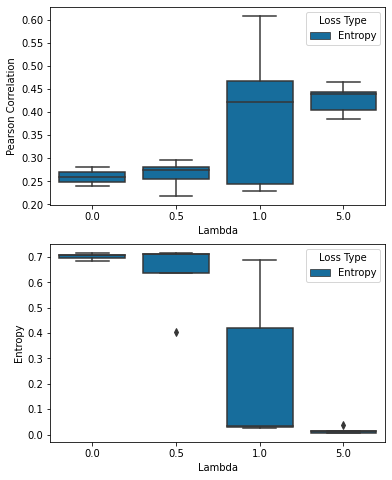

In [ ]:
fig = vae_box_plots(pd.read_csv('experiments/results/mnist/entropy_vae/metrics.csv'), metric_names, loss='entropy')
fig.savefig('experiments/results/mnist/entropy_vae/entropy_boxplots.pdf')

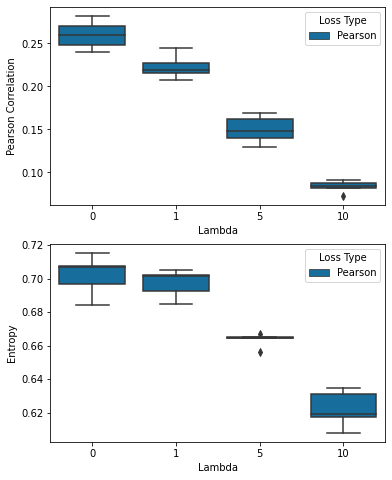

In [ ]:
fig = vae_box_plots(pd.read_csv('experiments/results/mnist/pearson_vae/metrics.csv'), metric_names, loss='pearson')
fig.savefig('experiments/results/mnist/pearson_vae/pearson_boxplots.pdf')